# Price Forecast Model

This notebook contains the exploratory data analysis, model training, and evaluation steps for the price forecasting model.

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style='whitegrid')

In [25]:
# Load the dataset
df = pd.read_csv(r'C:\Users\40108378\OneDrive - Anheuser-Busch InBev\Hedging Commodities\price-forecast-model\data\SAFEX_wheat_friday_df.csv')

# Display the first few rows of the dataset
df.head()

,Date,Price,volume,open_price,USDZAR Curncy,W 1 Comdty,W 2 Comdty,WZ1 Comdty,YW1 Comdty,Price_diff,year_month,max_temp,precipitation,avg_temp,min_temp,active_flag,day
0,2015-03-27,3800.0,139.0,3780.0,12.0438,507.75,512.00,2634.0,2422.0,5.0,201503.0,79.0489,2.195833,68.6914,58.31695,0,Friday
1,2015-04-03,3800.0,1.0,3800.0,11.9878,528.50,529.50,2608.0,2422.0,-30.0,201504.0,73.7244,0.994166,62.3620,50.99110,1,Friday
2,2015-04-10,3800.0,1.0,3800.0,11.9878,528.50,529.50,2608.0,2422.0,-30.0,201504.0,73.7244,0.994166,62.3620,50.99110,1,Friday
3,2015-04-17,3700.0,15.0,3705.0,12.0675,494.50,489.25,2557.0,2379.0,-40.0,201504.0,73.7244,0.994166,62.3620,50.99110,0,Friday
4,2015-04-24,3790.0,205.0,3750.0,12.1222,486.00,488.50,2576.0,2384.0,57.0,201504.0,73.7244,0.994166,62.3620,50.99110,0,Friday


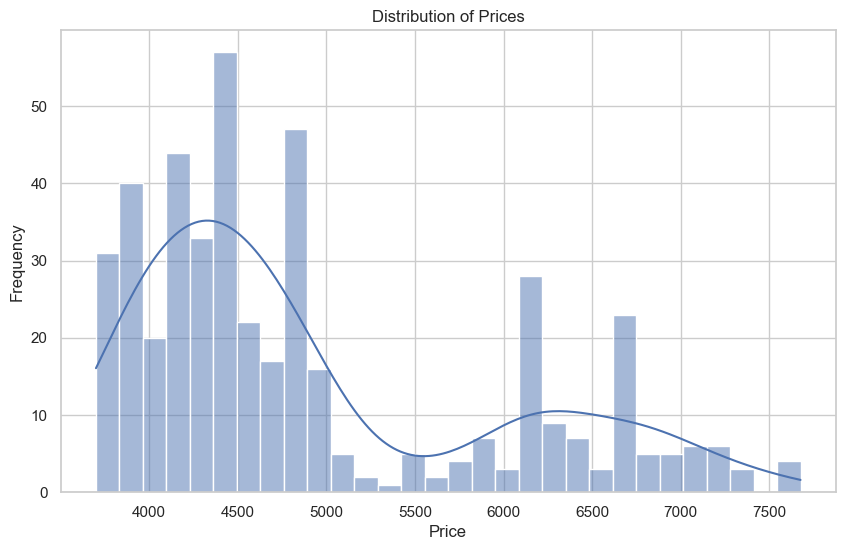

In [26]:
# Exploratory Data Analysis
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create covid_flag for data in 2020
df['covid_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2020 else 0)

# Create war_flag for data in 2022
df['war_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2022 else 0)

# Display the updated dataframe
df[['Date', 'covid_flag', 'war_flag']].head()
# Add a seasonality column based on the month
df['seasonality'] = df['Date'].dt.month % 12 // 3 + 1


# Display the updated dataframe with the new column
df[['Date', 'seasonality']].head()



,Date,seasonality
0,2015-03-27,2
1,2015-04-03,2
2,2015-04-10,2
3,2015-04-17,2
4,2015-04-24,2


In [28]:
from lightgbm import LGBMRegressor

In [29]:
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA

# Initialize the starting point for the loop
current_date = pd.Timestamp('2023-05-05')
horizon = 32  # Number of weeks to extrapolate

# Loop until the end of December 2023
while current_date <= pd.Timestamp('2023-12-31'):
    data_2022_2023 = df[df['Date'] < current_date]
    for i in range (0, horizon):
        # Use 20-day moving averages for extrapolation
        forecasted_values = {}
        for column in ['Price_diff', 'volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty', 
                   'WZ1 Comdty', 'YW1 Comdty', 'max_temp', 'precipitation', 'avg_temp', 'min_temp']:
            if len(data_2022_2023[column]) >= 20:
                forecasted_values[column] = data_2022_2023[column].rolling(window=156).mean().iloc[-1]
            else:
                forecasted_values[column] = data_2022_2023[column].mean()

        # Create a new row with extrapolated data
        new_row = {
            'Date': current_date + timedelta(weeks=i),
            'volume': forecasted_values['volume'],
            'open_price': forecasted_values['open_price'],
            'USDZAR Curncy': forecasted_values['USDZAR Curncy'],
            'W 1 Comdty': forecasted_values['W 1 Comdty'],
            'W 2 Comdty': forecasted_values['W 2 Comdty'],
            'WZ1 Comdty': forecasted_values['WZ1 Comdty'],
            'YW1 Comdty': forecasted_values['YW1 Comdty'],
            'Price_diff': forecasted_values['Price_diff'],
            'year_month': (current_date + timedelta(weeks=i)).year * 100 + (current_date + timedelta(weeks=i)).month,
            'max_temp': forecasted_values['max_temp'],
            'precipitation': forecasted_values['precipitation'],
            'avg_temp': forecasted_values['avg_temp'],
            'min_temp': forecasted_values['min_temp'],
            'active_flag': 0,
            'covid_flag': 0,
            'war_flag': 0,
            'day': 'Friday',
            'seasonality': (current_date + timedelta(weeks=i)).month % 12 // 3 + 1
        }
        # Append the new row to the dataframe
        data_2022_2023 = pd.concat([data_2022_2023, pd.DataFrame([new_row])], ignore_index=True)
    print(f"Extrapolated data until {current_date + timedelta(weeks=horizon)}")
    print(data_2022_2023.tail(32))
    # Prepare the data for training
    features = ['volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty', 
                'WZ1 Comdty', 'YW1 Comdty', 'Price_diff', 'max_temp', 'precipitation', 
                'avg_temp', 'min_temp']
    target = 'Price'
    X_train = df[df['Date'] <= current_date][features].astype(float)
    y_train = df[df['Date'] <= current_date][target].astype(float)
    X_test = data_2022_2023[data_2022_2023['Date'] > current_date][features].astype(float)
    y_test = df[df['Date'] > current_date][target].astype(float)
    # Train the XGB model
    lgbm_model = LGBMRegressor(random_state=42, max_depth=5, n_estimators=100, learning_rate=0.2)
    # Drop NaN values from training data
    print(X_train.isnull().sum())
    print(y_train.isnull().sum())
    # Train the XGB model
    xgb_model = XGBRegressor(random_state=42, max_depth=5, n_estimators=100, learning_rate=0.2)
    xgb_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    print(len(y_pred))
    print(len(y_test))  
    horizon_array = np.arange(1, horizon + 1)
    # Ensure the lengths of y_pred and horizon_array match
    if len(y_pred) != len(horizon_array):
        horizon_array = horizon_array[:len(y_pred)]

    # Create a DataFrame for predictions
    prediction_current_date = pd.DataFrame({
        'Date': X_test.index,
        'Predicted_Price': y_pred,
        'Horizon': horizon_array
    })
    prediction_current_date = pd.DataFrame({'Date': X_test.index, 'Predicted_Price': y_pred, 'Horizon':horizon_array })
    current_date_str = current_date.strftime('%Y-%m-%d')
    prediction_current_date.to_csv(f'predictions_{current_date_str}.csv', index=False)
    
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")
    current_date += timedelta(weeks=1)
    horizon -= 1
    

Extrapolated data until 2023-12-15 00:00:00
          Date  Price      volume   open_price  USDZAR Curncy  W 1 Comdty  \
423 2023-05-05    NaN  905.602564  5820.365385      16.118746  712.642628   
424 2023-05-12    NaN  911.055145  5826.265163      16.104459  713.816619   
425 2023-05-19    NaN  916.267037  5832.010452      16.088526  715.185636   
426 2023-05-26    NaN  919.198236  5838.273340      16.078694  716.508942   
427 2023-06-02    NaN  924.417455  5845.044323      16.069285  717.763807   
428 2023-06-09    NaN  926.202182  5852.031786      16.064095  719.061972   
429 2023-06-16    NaN  927.357324  5858.775580      16.057593  720.453395   
430 2023-06-23    NaN  926.667307  5865.274141      16.049426  721.986750   
431 2023-06-30    NaN  926.427995  5871.750257      16.041438  723.576409   
432 2023-07-07    NaN  926.828175  5878.620451      16.035029  724.894206   
433 2023-07-14    NaN  928.775791  5885.259044      16.030206  726.106669   
434 2023-07-21    NaN  930.72948

ValueError: Per-column arrays must each be 1-dimensional

In [30]:
import os
# Define the directory where the prediction CSV files are stored
predictions_dir = r'./'  # Replace with the actual directory path if different

# List all CSV files in the directory
csv_files = [file for file in os.listdir(predictions_dir) if file.startswith('predictions_') and file.endswith('.csv')]

# Initialize an empty list to store DataFrames
predictions_list = []
# Extract the date from the file name and add it as a new column
for file in csv_files:
    file_date = file.split('_')[1].split('.')[0]  # Extract the date part from the file name
    df_new = pd.read_csv(os.path.join(predictions_dir, file))
    df_new['File_Date'] = file_date  # Add the extracted date as a new column
    predictions_list.append(df_new)

# Concatenate all DataFrames into a single DataFrame
all_predictions = pd.concat(predictions_list, ignore_index=True)

# Display the combined DataFrame
print(all_predictions.head())
print(f"Total predictions loaded: {len(all_predictions)}")


   Date  Predicted_Price  Horizon   File_Date
0   424        5738.3100        1  2023-05-01
1   425        5738.3100        2  2023-05-01
2   426        5738.3100        3  2023-05-01
3   427        5738.3125        4  2023-05-01
4   428        5738.3125        5  2023-05-01
Total predictions loaded: 1025


In [31]:
# Convert 'File_Date' to datetime format
all_predictions['File_Date'] = pd.to_datetime(all_predictions['File_Date'])

# Calculate the prediction date by adding the horizon in weeks
all_predictions['prediction_date'] = all_predictions['File_Date'] + pd.to_timedelta(all_predictions['Horizon'], unit='W')

# Display the updated DataFrame
print(all_predictions.head())

   Date  Predicted_Price  Horizon  File_Date prediction_date
0   424        5738.3100        1 2023-05-01      2023-05-08
1   425        5738.3100        2 2023-05-01      2023-05-15
2   426        5738.3100        3 2023-05-01      2023-05-22
3   427        5738.3125        4 2023-05-01      2023-05-29
4   428        5738.3125        5 2023-05-01      2023-06-05


In [32]:
all_predictions.drop(columns=['Date'], inplace=True)
all_predictions.rename(columns={'prediction_date': 'Date'}, inplace=True)

In [33]:
# Ensure the 'Date' column in both DataFrames is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'], errors='coerce')

# Convert the 'Date' columns to string format for matching
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
all_predictions['Date'] = all_predictions['Date'].dt.strftime('%Y-%m-%d')

# Merge the DataFrames on the 'Date' column
merged_predictions = all_predictions.merge(df[['Date', 'Price']], on='Date', how='left')

# Display the merged DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date  Price
0        5738.3100        1 2023-05-01  2023-05-08    NaN
1        5738.3100        2 2023-05-01  2023-05-15    NaN
2        5738.3100        3 2023-05-01  2023-05-22    NaN
3        5738.3125        4 2023-05-01  2023-05-29    NaN
4        5738.3125        5 2023-05-01  2023-06-05    NaN


In [34]:
# Map the 'File_Date' to the corresponding 'Price' from the 'df' DataFrame
merged_predictions['Trained_Price'] = merged_predictions['File_Date'].dt.strftime('%Y-%m-%d').map(
    df.set_index('Date')['Price']
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date  Price  Trained_Price
0        5738.3100        1 2023-05-01  2023-05-08    NaN            NaN
1        5738.3100        2 2023-05-01  2023-05-15    NaN            NaN
2        5738.3100        3 2023-05-01  2023-05-22    NaN            NaN
3        5738.3125        4 2023-05-01  2023-05-29    NaN            NaN
4        5738.3125        5 2023-05-01  2023-06-05    NaN            NaN


In [35]:
# Calculate MAPE
merged_predictions['mape'] = abs(merged_predictions['Predicted_Price'] - merged_predictions['Price']) / merged_predictions['Price']

# Calculate Directional Accuracy
merged_predictions['dir_acc'] = merged_predictions.apply(
    lambda row: 1 if (
        (row['Price'] > row['Trained_Price'] and row['Predicted_Price'] > row['Trained_Price']) or
        (row['Price'] < row['Trained_Price'] and row['Predicted_Price'] < row['Trained_Price']) or
        (row['Price'] == row['Trained_Price'])
    ) else 0, axis=1
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date  Price  Trained_Price  \
0        5738.3100        1 2023-05-01  2023-05-08    NaN            NaN   
1        5738.3100        2 2023-05-01  2023-05-15    NaN            NaN   
2        5738.3100        3 2023-05-01  2023-05-22    NaN            NaN   
3        5738.3125        4 2023-05-01  2023-05-29    NaN            NaN   
4        5738.3125        5 2023-05-01  2023-06-05    NaN            NaN   

   mape  dir_acc  
0   NaN        0  
1   NaN        0  
2   NaN        0  
3   NaN        0  
4   NaN        0  


In [36]:
merged_predictions=merged_predictions.dropna(axis=0, how='any')

In [37]:
# Group by 'Horizon' and calculate the sum and count of 'dir_acc' values
horizon_dir_acc_stats = merged_predictions.groupby('Horizon')['dir_acc'].agg(['sum', 'count'])

# Calculate the percentage
horizon_dir_acc_stats['percentage'] = (horizon_dir_acc_stats['sum'] / horizon_dir_acc_stats['count']) * 100

# Average MAPE
horizon_dir_acc_stats['avg_mape'] = merged_predictions.groupby('Horizon')['mape'].mean()

# Display the result
print(horizon_dir_acc_stats)

         sum  count  percentage  avg_mape
Horizon                                  
1         19     31   61.290323  0.053883
2         18     30   60.000000  0.052482
3         14     29   48.275862  0.050481
4         17     28   60.714286  0.050183
5         18     27   66.666667  0.048445
6         19     26   73.076923  0.048167
7         16     25   64.000000  0.047520
8         19     24   79.166667  0.044515
9         19     23   82.608696  0.043384
10        17     22   77.272727  0.042897
11        17     21   80.952381  0.042718
12        19     20   95.000000  0.040480
13        17     19   89.473684  0.040470
14        17     18   94.444444  0.039004
15        16     17   94.117647  0.036648
16        15     16   93.750000  0.035739
17        14     15   93.333333  0.034081
18        13     14   92.857143  0.034137
19        12     13   92.307692  0.033536
20        11     12   91.666667  0.033237
21        10     11   90.909091  0.032395
22        10     10  100.000000  0

In [33]:
sum_dir_acc = merged_predictions['dir_acc'].sum()
print(sum_dir_acc)

390
